In [198]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from tqdm.auto import tqdm
import scipy as sp

sns.set_style("ticks", {"axes.grid": True, "grid.color": "0.95", "grid.linestyle": "-"})
sns.set_context("notebook", font_scale=1)

# Import Data

In [199]:
fed_trades_df = pd.read_csv('../data/clean/fed_trades.csv')

In [200]:
RV_daily_df = pd.read_csv('../data/clean/RV_daily.csv')

# Clean Data

In [201]:
def get_ticker_type(ticker_desc):
    
    ticker_maturity_type = ''
    ticker_yield_type = ''
    
    # Maturity type
    if 'short' in ticker_desc.lower() or '0-5' in ticker_desc:
        ticker_maturity_type = 'Short-Term'
    elif 'intermediate' in ticker_desc.lower():
        ticker_maturity_type = 'Intermediate'
    elif 'angel' in ticker_desc.lower():
        ticker_maturity_type = 'Mixed'
    elif 'iboxx high yield' in ticker_desc.lower():
        ticker_maturity_type = 'Mixed'
    elif 'xtrackers' in ticker_desc.lower():
        ticker_maturity_type = 'Mixed'
    elif 'bloomberg barclays high yield' in ticker_desc.lower():
        ticker_maturity_type = 'Mixed'
    elif 'ishares iboxx us dollar' in ticker_desc.lower():
        ticker_maturity_type = 'Intermediate'
    elif 'iShares Broad US Dollar High Yield Corporate'.lower() in ticker_desc.lower():
        ticker_maturity_type = 'Mixed'
    elif 'iShares Broad US Dollar Investment Grade'.lower() in ticker_desc.lower():
        ticker_maturity_type = 'Mixed'
        
    # Yield type
    if 'high' in ticker_desc.lower():
        ticker_yield_type = 'High Yield'
    else: #'investment grade' in ticker_desc.lower():
        ticker_yield_type = 'Investment Grade'
        
    return (ticker_maturity_type, ticker_yield_type)
        
fed_trades_df['ticker_maturity_type'] = fed_trades_df['ticker_desc'].apply(lambda x: get_ticker_type(x)[0])
fed_trades_df['ticker_yield_type'] = fed_trades_df['ticker_desc'].apply(lambda x: get_ticker_type(x)[1])
fed_trades_df['ticker_type'] = fed_trades_df['ticker_maturity_type'] + ' ' + fed_trades_df['ticker_yield_type']

In [202]:
# Fix dates
fed_trades_df['date'] = (pd.to_datetime(fed_trades_df['trade_date']).dt.date).astype(str)
RV_daily_df['date'] = (pd.to_datetime(RV_daily_df['date']).dt.date).astype(str)

In [203]:
# Add ticker info
data_df = RV_daily_df.merge(
    fed_trades_df[
        ["ticker", "ticker_desc", "ticker_type", "ticker_yield_type", "ticker_maturity_type"]
    ].drop_duplicates(),
    on=["ticker"],
    how="inner",
)

In [204]:
# Add shares purchased for each ticker on each day
fed_shares_purchased_df = (
    fed_trades_df.groupby(["date", "ticker"])["shares_purchased"].sum().reset_index()
)
data_df = data_df.merge(
    fed_shares_purchased_df, on=["date", "ticker"], how="left"
)
data_df["shares_purchased"] = data_df["shares_purchased"].fillna(0)

In [205]:
# True/false depending on whether fed purchased the ticker that day
data_df["fed_purchased_shares"] = data_df["shares_purchased"] > 0

In [206]:
# Add annualized realized volatility
data_df['Rvol_annual'] = np.sqrt(data_df['RV']*252)

In [207]:
data_df.head()

,ticker,date,RV,ticker_desc,ticker_type,ticker_yield_type,ticker_maturity_type,shares_purchased,fed_purchased_shares,Rvol_annual
0,ANGL,2020-04-01,0.001697,VanEck Vectors Fallen Angel High Yield Bond ETF,Mixed High Yield,High Yield,Mixed,0.0,False,0.653867
1,ANGL,2020-04-02,0.000708,VanEck Vectors Fallen Angel High Yield Bond ETF,Mixed High Yield,High Yield,Mixed,0.0,False,0.422326
2,ANGL,2020-04-03,0.001270,VanEck Vectors Fallen Angel High Yield Bond ETF,Mixed High Yield,High Yield,Mixed,0.0,False,0.565752
3,ANGL,2020-04-06,0.000761,VanEck Vectors Fallen Angel High Yield Bond ETF,Mixed High Yield,High Yield,Mixed,0.0,False,0.438030
4,ANGL,2020-04-07,0.002098,VanEck Vectors Fallen Angel High Yield Bond ETF,Mixed High Yield,High Yield,Mixed,0.0,False,0.727067


# Stats

In [208]:
temp_df = fed_trades_df.sample(5).sort_values(by="trade_date")[
    ["trade_date", "ticker", "ticker_desc", "shares_purchased", "price_per_share"]
]
display(temp_df)

with pd.option_context("max_colwidth", 40):
    temp_df["trade_date"] = (pd.to_datetime(temp_df["trade_date"]).dt.date).astype(str)
    print(temp_df.round(2).set_index("trade_date").to_latex())

,trade_date,ticker,ticker_desc,shares_purchased,price_per_share
94,2020-05-14,USIG,iShares Broad US Dollar Investment Grade Corpo...,9794,57.8300
486,2020-05-20,USIG,iShares Broad US Dollar Investment Grade Corpo...,6899,58.6300
244,2020-05-21,IGSB,iShares Short-Term Corporate Bond ETF,312119,54.0666
616,2020-06-23,IGIB,iShares Intermediate-Term Corporate Bond ETF,43052,60.1300
673,2020-06-23,SPSB,SPDR Portfolio Short Term Corporate Bond ETF,82668,31.3100


\begin{tabular}{lllrr}
\toprule
{} & ticker &                              ticker\_desc &  shares\_purchased &  price\_per\_share \\
trade\_date &        &                                          &                   &                  \\
\midrule
2020-05-14 &   USIG &  iShares Broad US Dollar Investment G... &              9794 &            57.83 \\
2020-05-20 &   USIG &  iShares Broad US Dollar Investment G... &              6899 &            58.63 \\
2020-05-21 &   IGSB &    iShares Short-Term Corporate Bond ETF &            312119 &            54.07 \\
2020-06-23 &   IGIB &  iShares Intermediate-Term Corporate ... &             43052 &            60.13 \\
2020-06-23 &   SPSB &  SPDR Portfolio Short Term Corporate ... &             82668 &            31.31 \\
\bottomrule
\end{tabular}



In [209]:
with pd.option_context("max_colwidth", 45):
    print(fed_trades_df.groupby(['ticker']).first()[['ticker_desc', 'ticker_type']].to_latex().replace('   ', ' '))

\begin{tabular}{lll}
\toprule
{} &             ticker\_desc &        ticker\_type \\
ticker &                 &            \\
\midrule
ANGL &  VanEck Vectors Fallen Angel High Yield Bo... &     Mixed High Yield \\
HYG  & iShares iBoxx High Yield Corporate Bond ETF &     Mixed High Yield \\
HYLB &  Xtrackers US Dollar High Yield Corporate ... &     Mixed High Yield \\
IGIB &  iShares Intermediate-Term Corporate Bond ETF &  Intermediate Investment Grade \\
IGSB &   iShares Short-Term Corporate Bond ETF &  Short-Term Investment Grade \\
JNK  & SPDR Bloomberg Barclays High Yield Bond ETF &     Mixed High Yield \\
LQD  &  iShares iBoxx US Dollar Investment Grade ... &  Intermediate Investment Grade \\
SHYG &  iShares 0-5 Year High Yield Corporate Bon... &    Short-Term High Yield \\
SJNK &  SPDR Bloomberg Barclays Short Term High Y... &    Short-Term High Yield \\
SLQD &  iShares 0-5 Year Investment Grade Corpora... &  Short-Term Investment Grade \\
SPIB &  SPDR Portfolio Intermediate Term 

In [210]:
print(f"Total purchase amount: ${(fed_trades_df['purchase_amount'].sum()):,}")

Total purchase amount: $8,434,795,267.6


In [211]:
print(f"Unique bonds: {len(fed_trades_df['ticker'].unique())}")

Unique bonds: 16


In [212]:
print(', '.join(['\$' + x for x in fed_trades_df['ticker'].unique()]))

\$VCIT, \$HYG, \$SLQD, \$VCSH, \$SPSB, \$JNK, \$USHY, \$IGIB, \$LQD, \$USIG, \$IGSB, \$SPIB, \$ANGL, \$HYLB, \$SHYG, \$SJNK


In [213]:
', '.join(fed_trades_df['sponsor'].unique())

'Vanguard, BlackRock, State Street, VanEck, Deutsche Bank, DWS, State Street '

# Exhibits

## Fed Purchases

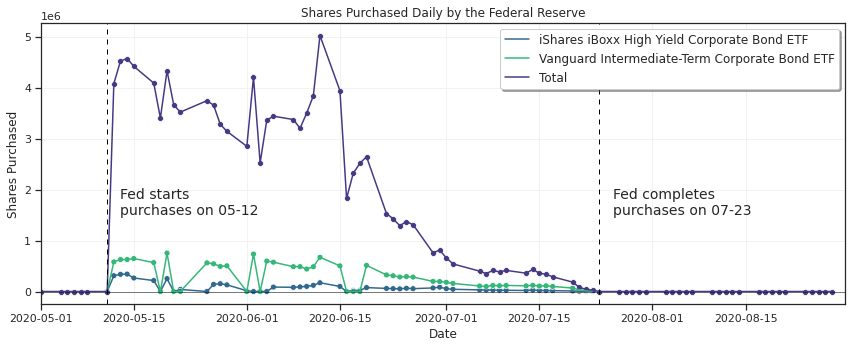

In [252]:
ticker_subset = ["VCIT", "HYG"]
data_df["date"] = pd.to_datetime(data_df["date"])
plot_data = (
    data_df.groupby(["ticker", "ticker_desc", pd.Grouper(key="date", freq="d")])["shares_purchased"]
    .sum()
    .reset_index()
).query('date >= "2020-05-11" & date <= "2020-07-23"')

fig, ax = plt.subplots(figsize=(12, 5))
sns.set_context("notebook", font_scale=1)

# Line across 0
ax.axhline(0, 0, 1, color="k", lw=0.5)
# Each bond
sns.lineplot(
    x="date",
    y="shares_purchased",
    hue="ticker_desc",
    palette=sns.color_palette("viridis", len(ticker_subset)),
    data=plot_data.query("ticker in @ticker_subset"),
    ax=ax,
)
sns.scatterplot(
    x="date",
    y="shares_purchased",
    hue="ticker_desc",
    palette=sns.color_palette("viridis", len(ticker_subset)),
    data=plot_data.query("ticker in @ticker_subset"),
    ax=ax,
)
# Total
sns.scatterplot(
    x="date",
    y="shares_purchased",
    color=sns.color_palette("viridis", 5)[0],
    data=data_df.groupby("date")["shares_purchased"].sum().reset_index(),
    label="Total",
    ax=ax,
)
sns.lineplot(
    x="date",
    y="shares_purchased",
    color=sns.color_palette("viridis", 5)[0],
    data=data_df.groupby("date")["shares_purchased"].sum().reset_index(),
    label="Total",
    ax=ax,
)
plt.axvline(pd.to_datetime("2020-05-11"), 0, 1, color="k", ls=(0,(5,5)), lw=1)
plt.text(
    pd.to_datetime("2020-05-13 00:00:00"),
    1.8e6,
    "Fed starts \npurchases on 05-12",
    size=14,
    ha="left",
    va="center_baseline",
)
plt.axvline(pd.to_datetime("2020-07-24"), 0, 1, color="k", ls=(0,(5,5)), lw=1)
plt.text(
    pd.to_datetime("2020-07-26 00:00:00"),
    1.8e6,
    "Fed completes \npurchases on 07-23",
    size=14,
    ha="left",
    va="center_baseline",
)

# Settings
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m-%d"))
plt.ylabel("Shares Purchased")
plt.xlabel("Date")
plt.title("Shares Purchased Daily by the Federal Reserve")
plt.xlim(pd.to_datetime('2020-05-01'), pd.to_datetime('2020-08-30'))

# Fix legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    loc="upper right", handles=handles[1:4], labels=labels[1:4], title="", fontsize=12, ncol=1, shadow=True
)

# Save
plt.tight_layout()
plt.savefig("../exhibits/fed_shares_purchased_daily.pdf")

## Realized Volatility

In [215]:
def t_and_u_test(data_df_1, data_df_2):
    
    # T-test change (means)
    ttest_t, ttest_p = sp.stats.ttest_ind(
        data_df_1,
        data_df_2,
        equal_var=False,
    )

    # U-test change (medians)
    utest_u, utest_p = sp.stats.mannwhitneyu(
        data_df_1,
        data_df_2,
        alternative="two-sided",
    )
    
    return ttest_t, ttest_p, utest_u, utest_p

In [216]:
# Trimming 5% of outliers
lower, upper = data_df.query('date <= "2020-08-30" & date > "2020-05-01"')['RV'].quantile([0.025, 0.975]).values

In [217]:
data_trim_df = data_df.query('date <= "2020-08-30" & date > "2020-05-01"').query('RV > @lower & RV < @upper').copy()

### All Bonds

In [240]:
results = data_trim_df.groupby(['fed_purchased_shares'])['Rvol_annual'].describe()
display(results)
print(results.round(4).to_latex())

,count,mean,std,min,25%,50%,75%,max
fed_purchased_shares,,,,,,,,
False,594.0,0.065958,0.044817,0.020702,0.037352,0.052314,0.078149,0.294751
True,666.0,0.083166,0.052102,0.022572,0.045515,0.068056,0.102992,0.288440


\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &    mean &     std &     min &     25\% &     50\% &     75\% &     max \\
fed\_purchased\_shares &        &         &         &         &         &         &         &         \\
\midrule
False                &  594.0 &  0.0660 &  0.0448 &  0.0207 &  0.0374 &  0.0523 &  0.0781 &  0.2948 \\
True                 &  666.0 &  0.0832 &  0.0521 &  0.0226 &  0.0455 &  0.0681 &  0.1030 &  0.2884 \\
\bottomrule
\end{tabular}



In [219]:
results.T.iloc[:,1]/results.T.iloc[:,0]

count    1.121212
mean     1.260889
std      1.162555
min      1.090314
25%      1.218517
50%      1.300906
75%      1.317893
max      0.978587
dtype: float64

In [220]:
test_results = t_and_u_test(data_trim_df.query('fed_purchased_shares == True')['Rvol_annual'],
    data_trim_df.query('fed_purchased_shares == False')['Rvol_annual'])

print(f't-test p: {test_results[1]}\nu-test p: {test_results[-1]}')

t-test p: 4.07424257440792e-10
u-test p: 9.799919074882714e-13


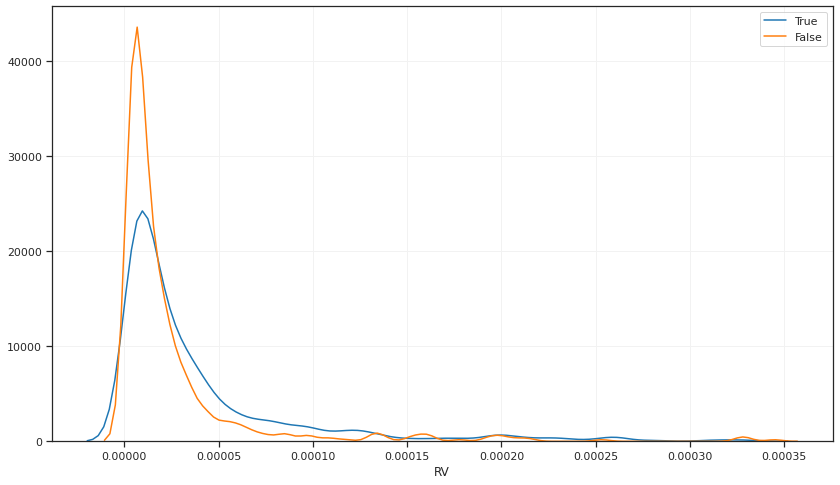

In [221]:
## Distribution of RV based on whether fed purchased shares
fig,ax = plt.subplots(figsize = (14,8))
sns.distplot(data_trim_df.query('fed_purchased_shares == True')['RV'], label = 'True', hist = False, ax = ax)
sns.distplot(data_trim_df.query('fed_purchased_shares == False')['RV'], label = 'False', hist = False, ax = ax)

### Split by Bond Type

In [222]:
results = (
    data_trim_df
    .groupby(["ticker_type", "fed_purchased_shares"])["Rvol_annual"]
    .describe()
).iloc[::-1]
display(results)

for ttype, df in results.reset_index(0).groupby('ticker_type'):
    print(ttype)
    print(df.drop('ticker_type', axis = 1).round(4).to_latex())

count      mean       std  \
ticker_type                   fed_purchased_shares                              
Short-Term Investment Grade   True                  155.0  0.044266  0.028856   
                              False                 143.0  0.038051  0.025993   
Short-Term High Yield         True                   65.0  0.082522  0.028217   
                              False                  99.0  0.076315  0.037596   
Mixed Investment Grade        True                   47.0  0.083332  0.041125   
                              False                  33.0  0.067629  0.032061   
Mixed High Yield              True                  219.0  0.117051  0.051379   
                              False                 176.0  0.090326  0.053593   
Intermediate Investment Grade True                  180.0  0.075626  0.051593   
                              False                 143.0  0.056319  0.035722   

                                                         min       25%  \
ticker_type                   fed_purchased_shares                       
Short-Term Investment Grade   True                  0.022572  0.031553   
                              False                 0.020702  0.026377   
Short-Term High Yield         True                  0.039028  0.064558   
                              False                 0.034035  0.052418   
Mixed Investment Grade        True                  0.042114  0.058645   
                              False                 0.034998  0.047792   
Mixed High Yield              True                  0.044649  0.080542   
                              False                 0.033642  0.052358   
Intermediate Investment Grade True                  0.025218  0.043597   
                              False                 0.020821  0.033679   

                                                         50%       75%  \
ticker_type                   fed_purchased_shares                       
Short-Term Investment Grade   True                  0.035822  0.047147   
                              False                 0.033112  0.040681   
Short-Term High Yield         True                  0.076984  0.095174   
                              False                 0.068684  0.087345   
Mixed Investment Grade        True                  0.073056  0.089952   
                              False                 0.057810  0.071327   
Mixed High Yield              True                  0.102858  0.141937   
                              False                 0.072850  0.104334   
Intermediate Investment Grade True                  0.056399  0.085361   
                              False                 0.044716  0.069157   

                                                         max  
ticker_type                   fed_purchased_shares            
Short-Term Investment Grade   True                  0.227253  
                              False                 0.288100  
Short-Term High Yield         True                  0.174364  
                              False                 0.252660  
Mixed Investment Grade        True                  0.288440  
                              False                 0.182194  
Mixed High Yield              True                  0.279909  
                              False                 0.294751  
Intermediate Investment Grade True                  0.284595  
                              False                 0.228070

Intermediate Investment Grade
\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &    mean &     std &     min &     25\% &     50\% &     75\% &     max \\
fed\_purchased\_shares &        &         &         &         &         &         &         &         \\
\midrule
True                 &  180.0 &  0.0756 &  0.0516 &  0.0252 &  0.0436 &  0.0564 &  0.0854 &  0.2846 \\
False                &  143.0 &  0.0563 &  0.0357 &  0.0208 &  0.0337 &  0.0447 &  0.0692 &  0.2281 \\
\bottomrule
\end{tabular}

Mixed High Yield
\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &    mean &     std &     min &     25\% &     50\% &     75\% &     max \\
fed\_purchased\_shares &        &         &         &         &         &         &         &         \\
\midrule
True                 &  219.0 &  0.1171 &  0.0514 &  0.0446 &  0.0805 &  0.1029 &  0.1419 &  0.2799 \\
False                &  176.0 &  0.0903 &  0.0536 &  0.0336 &  0.0524 &  0.0728 &  0.1043 &  0.2948 \\
\bottomrule
\end{tabular}

Mixed Inves

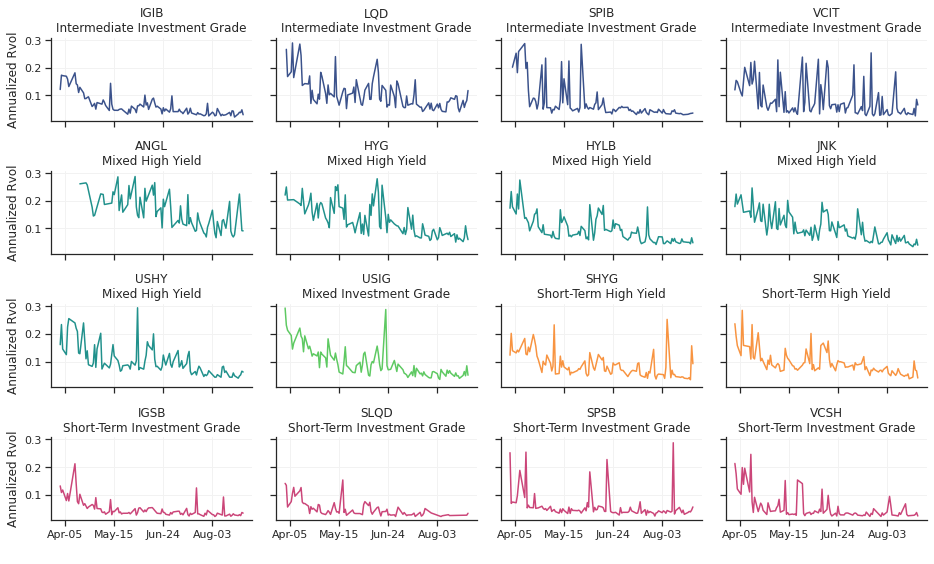

In [227]:
ticker_type_colors = dict(zip(data_trim_df.groupby('ticker_type').first().index, 
    (sns.color_palette("viridis", 3) + sns.color_palette("plasma_r", 3))))

data_df["date_dt"] = pd.to_datetime(data_df["date"])
g = sns.FacetGrid(
    data_df.query('RV < @upper & RV > @lower').sort_values(by=["ticker_type", "ticker", "date"]),
    col="ticker",
    col_wrap=4,
    sharex=True,
    aspect=1.65,
    height=2,
)
g = (
    g.map(plt.plot, "date_dt", "Rvol_annual")
    .set_titles("{col_name}")
    .set_axis_labels(" ", "Annualized Rvol")
)


# # Plot settings
ax = g.axes.flatten()
for i in range(16):
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    ticker = ax[i].get_title()
    ticker_type = data_trim_df.query("ticker == @ticker")["ticker_type"].iloc[0]
    ax[i].set_title(f"{ticker}\n{ticker_type}")
    ax[i].get_lines()[0].set_color(ticker_type_colors.get(ticker_type))

plt.tight_layout()
plt.savefig("../exhibits/rv_16tickers.pdf")

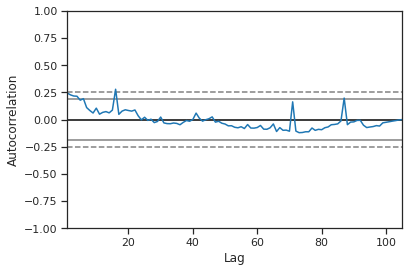

In [259]:
pd.plotting.autocorrelation_plot(data_df.sort_values(by=["ticker_type", "ticker", "date"]).query('ticker == "IGIB"')['Rvol_annual'])

(0.0, 30.0)

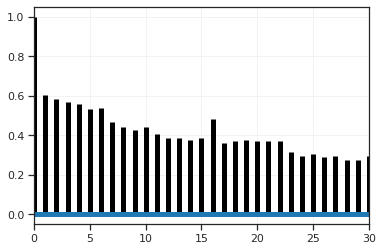

In [268]:
plt.acorr(data_df.sort_values(by=["ticker_type", "ticker", "date"]).query('ticker == "IGIB"')['Rvol_annual'], lw = 5, maxlags = 40)
plt.xlim(0,30)

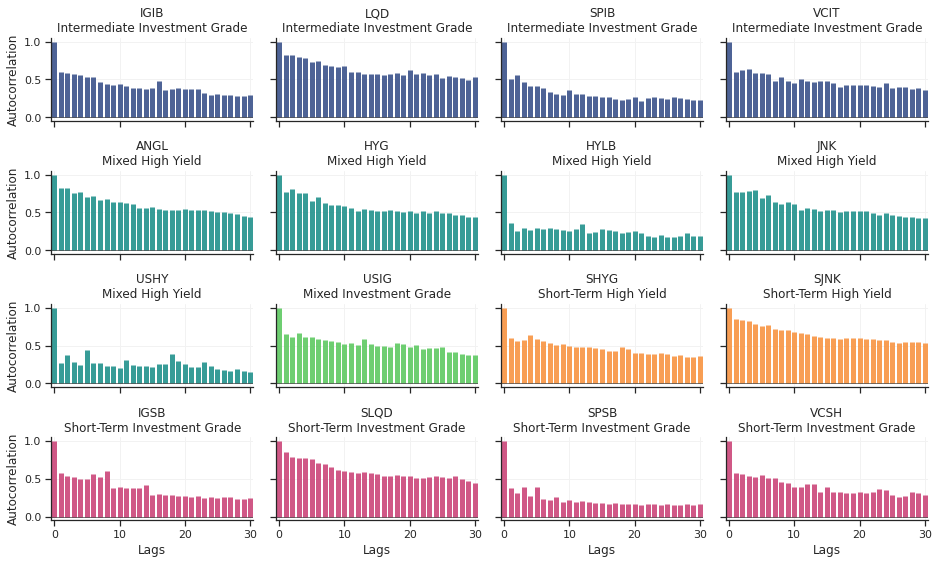

In [269]:
ticker_type_colors = dict(zip(data_trim_df.groupby('ticker_type').first().index, 
    (sns.color_palette("viridis", 3) + sns.color_palette("plasma_r", 3))))

data_df["date_dt"] = pd.to_datetime(data_df["date"])
g = sns.FacetGrid(
    data_df.sort_values(by=["ticker_type", "ticker", "date"]),
    col="ticker",
    col_wrap=4,
    sharex=True,
    aspect=1.65,
    height=2,
)
g = (
    g.map(plt.acorr, "Rvol_annual", **{'lw':5, 'maxlags':100})
    .set_titles("{col_name}")
    .set_axis_labels("Lags", "Autocorrelation")
)


# # Plot settings
ax = g.axes.flatten()
for i in range(16):
#     ax[i].xaxis.set_major_locator(plt.MaxNLocator(3))
    ticker = ax[i].get_title()
    ticker_type = data_trim_df.query("ticker == @ticker")["ticker_type"].iloc[0]
    ax[i].set_title(f"{ticker}\n{ticker_type}")
    ax[i].get_children()[0].set_color(ticker_type_colors.get(ticker_type))
    ax[i].get_children()[0].set_alpha(0.9)
    ax[i].get_lines()[0].set_linewidth(1)
    ax[i].get_lines()[0].set_alpha(0.5)
    ax[i].get_lines()[0].set_color([0,0,0])
    ax[i].set_xlim(-0.5, 30.5)

plt.tight_layout()
plt.savefig("../exhibits/rv_acorr_16tickers.pdf")

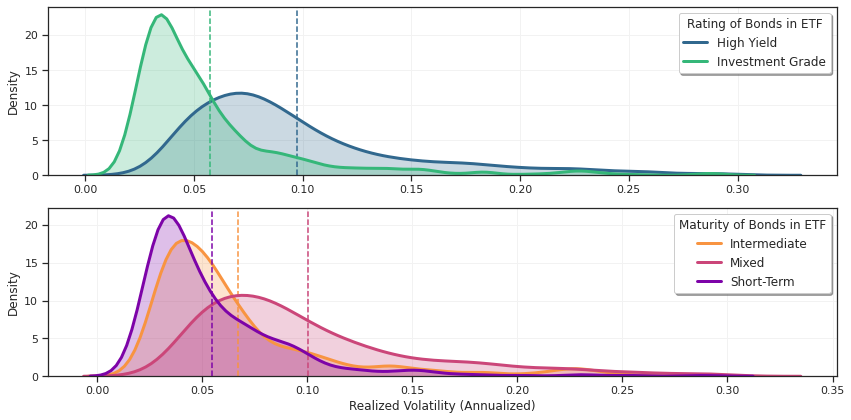

In [68]:
fig, ax = plt.subplots(figsize = (12,6), nrows=2, ncols=1, sharex = True)

## Rating Type
ax = plt.subplot(2, 1, 1)
plot_data_groups = data_trim_df.groupby(['ticker_yield_type'])

for i in range(len(plot_data_groups)):
    bond_type, bond_data = list(plot_data_groups)[i]
    plot_color = sns.color_palette("viridis", 2)[i]
    sns.distplot(bond_data['Rvol_annual'], color = plot_color,
                 label = bond_type, 
                 hist = False, ax = ax, kde_kws = {'linewidth': 3, 'shade':True})
    plt.axvline(bond_data['Rvol_annual'].mean(), ls = '--', color = plot_color)

plt.ylabel('Density')
plt.xlabel('')

# Fix legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    loc="upper right",
    title="Rating of Bonds in ETF",
    fontsize=12,
    ncol=1,
    shadow = True
)

## Rating Type
ax = plt.subplot(2, 1, 2)
plot_data_groups = data_trim_df.groupby(['ticker_maturity_type'])

for i in range(len(plot_data_groups)):
    bond_type, bond_data = list(plot_data_groups)[i]
    plot_color = sns.color_palette("plasma_r", 3)[i]
    sns.distplot(bond_data['Rvol_annual'], color = plot_color,
                 label = bond_type, 
                 hist = False, ax = ax, kde_kws = {'linewidth': 3, 'shade':True})
    plt.axvline(bond_data['Rvol_annual'].mean(), ls = '--', color = plot_color)

plt.ylabel('Density')
plt.xlabel('Realized Volatility (Annualized)')

# Fix legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    loc="upper right",
    title="Maturity of Bonds in ETF",
    fontsize=12,
    ncol=1,
    shadow = True
)

plt.tight_layout()
plt.savefig('../exhibits/dist_rv_rating_maturity.pdf')

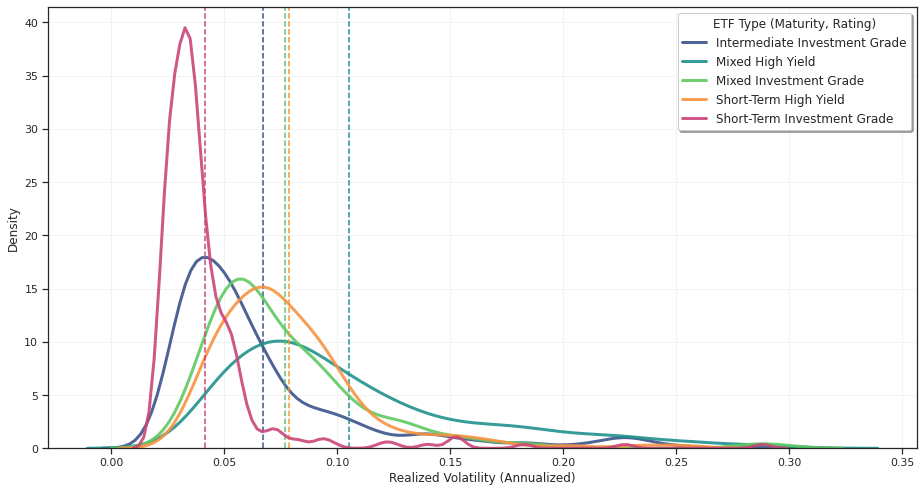

In [69]:
fig, ax = plt.subplots(figsize = (13,7))
plot_data_groups = data_trim_df.groupby(['ticker_type'])

for i in range(len(plot_data_groups)):
    bond_type, bond_data = list(plot_data_groups)[i]
    plot_color = (sns.color_palette("viridis", 3) + sns.color_palette("plasma_r", 3))[i]
    sns.distplot(bond_data['Rvol_annual'], color = plot_color,
                 label = bond_type, hist = False, ax = ax, kde_kws = {'linewidth': 3, 'alpha':0.9})
    plt.axvline(bond_data['Rvol_annual'].mean(), ls = '--', color = plot_color)

plt.ylabel('Density')
plt.xlabel('Realized Volatility (Annualized)')

# Fix legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    loc="upper right",
    title="ETF Type (Maturity, Rating)",
    fontsize=12,
    ncol=1,
    shadow = True
)

plt.tight_layout()
plt.savefig('../exhibits/dist_rv_type.pdf')